<center>
    <a href="https://rapids.ai/"><img width='80%' src='https://raw.githubusercontent.com/miroenev/rapids/master/rapids_workflow.png'></a></center>    


<h1>RAPIDS Demo - End-To-End ML Workflow</h1>
by Miro Enev

> 1. Motivate rapids [ show coverage of modern data science tools ]

> 2. Generate a synthetic dataset
    * 2.1 - Split into train and test set
    * 2.2 - Visualize sub-datasets

> 3. ETL
    * 3.1 - Load data [ csv read ]     
    * 3.2 - Transform data [ standard scaler ]

> 4. Model Building 
    * 4.1 - Train CPU and GPU XGBoost classifier models 
    * 4.2 - Use trained models for inference
    * 4.3 - Compare accuracy
    * 4.4 - Visualize sample boosted trees & model predictions

> 5. Extensions 
    * 5.1 - Create an ensemble with a clustering model [ DBScan ]
    * 5.2 - Export data to DeepLearning Framework [ PyTorch ]
    


In [1]:
import pandas as pd, numpy as np, sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score

import xgboost
from xgboost import plot_tree

import cuml, cudf, numba, scipy
from numba import cuda 
import time

useMatplotlib3DFlag = True
if useMatplotlib3DFlag:
    from mpl_toolkits.mplot3d import Axes3D
else:
    import ipyvolume as ipv

#import matplotlib.pyplot as plt
from fig_helpers import *


------
# 1. Motivation: Kaggle 2018 and 2017 Data Science Surveys
<img width='1200px' src='https://storage.googleapis.com/kaggle-datasets-images/70947/156853/3ef5dd03338ef20b7c6118e4ed600a87/dataset-cover.jpg?t=2018-11-05-19-24-06'></img> 
* https://www.kaggle.com/surveys/2018
* https://www.kaggle.com/surveys/2017

In [2]:
schemaFilePath_2018 = 'kaggle_data/2018/SurveySchema.csv'
schemaSurveyDF_2018 = pd.read_csv(schemaFilePath_2018)

surveyFilePath_2018 = 'kaggle_data/2018/multipleChoiceResponses.csv'
kaggleSurveyDF_2018 = pd.read_csv(surveyFilePath_2018, encoding="ISO-8859-1", low_memory=False)

schemaFilePath = 'kaggle_data/2017/schema.csv'
schemaSurveyDF = pd.read_csv(schemaFilePath)

surveyFilePath = 'kaggle_data/2017/multipleChoiceResponses.csv'
kaggleSurveyDF = pd.read_csv(surveyFilePath, encoding="ISO-8859-1", low_memory=False)

scrapedKernelMethodFilePath = 'kaggle_data/results.csv'
kaggleKernelMethodsDF = pd.read_csv(scrapedKernelMethodFilePath)

# What activities make up an important part of your role at work?


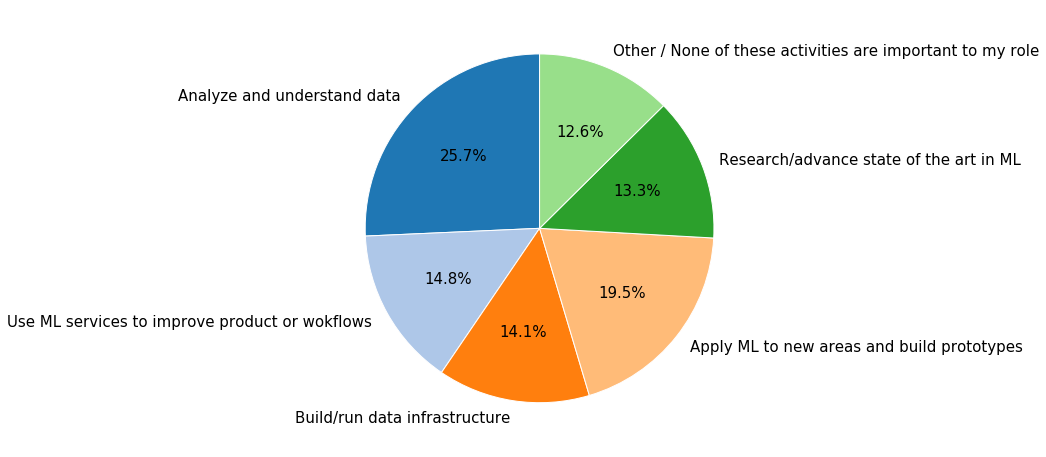

In [3]:
set_rcParams(); pie_plot_important_activities_2018(kaggleSurveyDF_2018, schemaSurveyDF_2018 )

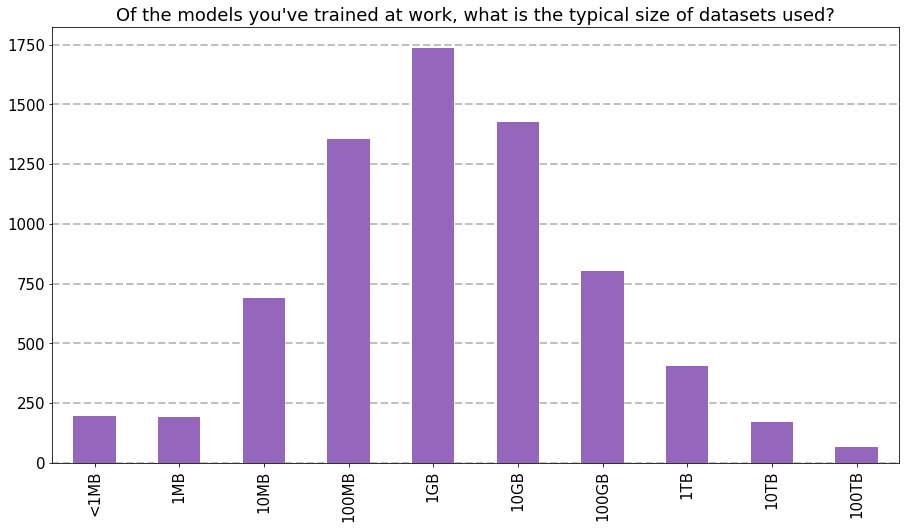

In [4]:
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, 119, nTopResults = 10, 
                  newIndex = ['<1MB', '1MB', '10MB', '100MB','1GB', '10GB',  '100GB', '1TB', '10TB', '100TB'])

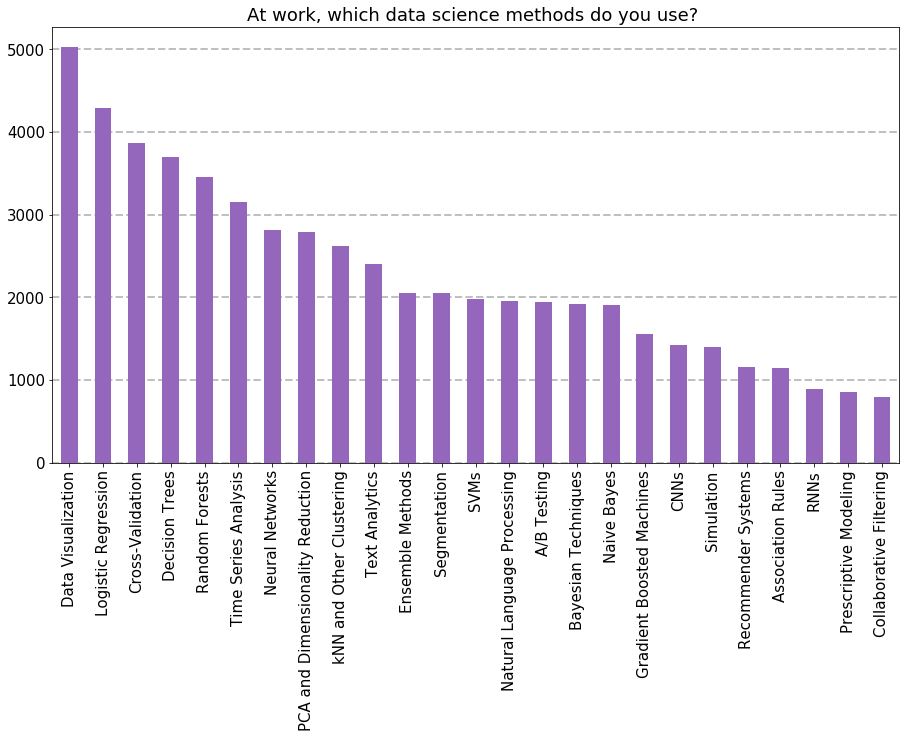

In [5]:
bar_plot_question(kaggleSurveyDF, schemaSurveyDF, 180, 25)

<Figure size 864x504 with 0 Axes>

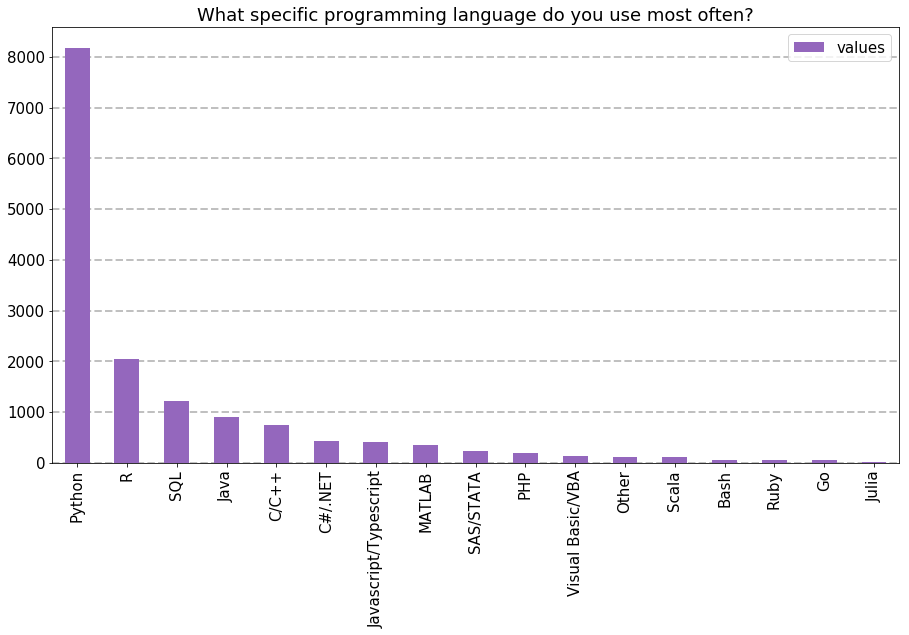

In [6]:
bar_plot_2018(kaggleSurveyDF_2018, schemaSurveyDF_2018, 17)

# Top pandas dataframe methods used 
> [ code scraped from top 1800 Kaggle notebooks ]

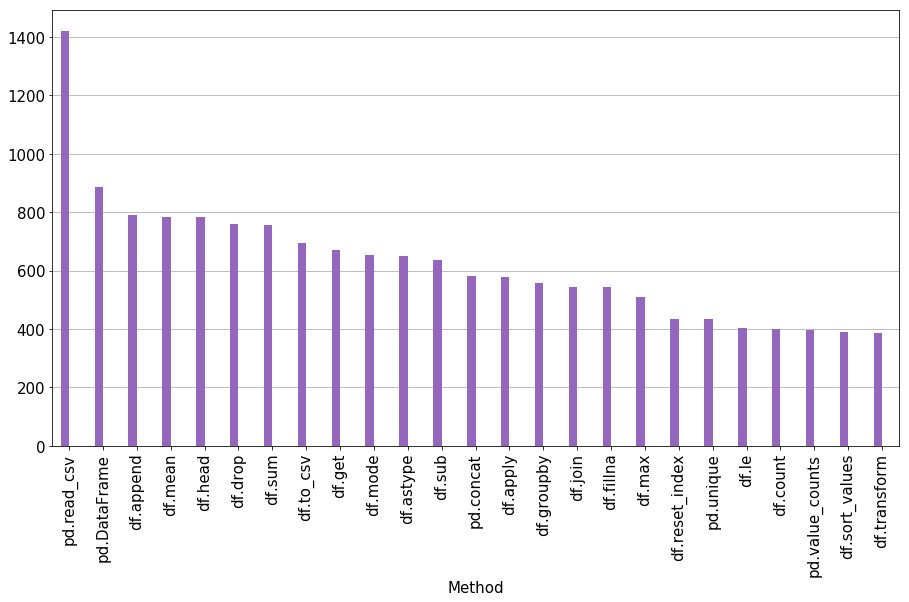

In [7]:
kaggleKernelMethodsDF.index = kaggleKernelMethodsDF['Method']
kaggleKernelMethodsDF.head(25).plot.bar(legend=False, alpha=1, color='tab:purple', rot=90); plt.gca().set_axisbelow(True); plt.gca().yaxis.grid(True)

-----
# 2. Generate Dataset [ X: features, y: labels ]

Set the size of the generated dataset -- the number of total samples is determined by this value

In [8]:
nTotalSamples = 50000000

Next we'll use <a href='https://scikit-learn.org/stable/datasets/index.html#generated-datasets'>sklearn.datasets</a> to build synthetic sub-datasets of the size we specified above. We'll build three sub-datasets and combine them together and then use a trained model to see if we can determine which of sub-dataset a sample belongs to. The three sub-datasets are built using the moons, blobs, and swiss-roll generators. These sub-datasets were selected for their distinct visual features.

In [9]:
%%time
nSamplesPerSubDataset = nTotalSamples//3

swissRollDataset = datasets.make_swiss_roll( n_samples = nSamplesPerSubDataset, noise = .005)[0]

moonsDataset = datasets.make_moons(n_samples = nSamplesPerSubDataset, noise = 0)[0]
moonsDataset = np.hstack( [moonsDataset, np.zeros( (moonsDataset.shape[0], 1) )] )*4

blobsDataset = datasets.make_blobs( n_samples = nSamplesPerSubDataset, centers = 5,  n_features = 3, 
                                    cluster_std = 0.25,  random_state = 0)[0] + [0, 1.5, 0]

CPU times: user 13.5 s, sys: 2.16 s, total: 15.7 s
Wall time: 15.7 s


In [10]:
X = np.vstack([blobsDataset, swissRollDataset, moonsDataset])

In [11]:
# generate labels for classification 
blobsLabels = np.zeros(blobsDataset.shape[0])
moonsLabels = 1 * np.ones(moonsDataset.shape[0])
sRollLabels = 2 * np.ones(swissRollDataset.shape[0])

y = np.hstack( [blobsLabels, sRollLabels, moonsLabels])

In [12]:
X.shape, y.shape

((49999998, 3), (49999998,))

## 2.1 - Split Train (75%) and Test (25%) Data 
We split our combined dataset into two portions:
* **train-set** - which we'll use to optimize our model's parameters [ train-set = randomly selected 75% of total data]
* **test-set** - which we'll use to evaluate how well our trained model performs on unseen data [ test-set = remaining 25% of data ]

In [13]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.25, random_state = 0, shuffle=True)

In [14]:
len(X_train), len(X_test)

(37499998, 12500000)

## 2.2 - Visualize Data
We define a function for plotting using either matplotlib Axes3D [ default ] or  <a href='https://github.com/maartenbreddels/ipyvolume'>ipyvolume</a> for WebGL based 3D plotting -- we restrict the maximum points to plot to `maxSamplesToPlot` which has a default setting of `100000`

In [15]:
def mpl_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 10000, 
                  ax3D = False, markerScale=1):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not ax3D:ax3D = plt.figure(figsize=(12,12)).gca(projection='3d')
            
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]
        
    ax3D.scatter(data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], s = 20*markerScale, c=colorStack, depthshade=False)
    
    ax3D.view_init(elev=10, azim=95)
    
def ipv_plot_data( data, colorStack = 'purple', 
                  maxSamplesToPlot = 100000, 
                  holdOnFlag = False, markerSize=.5):
    
    nSamplesToPlot = np.min( ( len(data), maxSamplesToPlot ) )
    if not holdOnFlag: ipv.figure(width=600,height=600)
        
    if isinstance(colorStack, np.ndarray):
        colorStack = colorStack[0:maxSamplesToPlot,:]

    ipv.scatter( data[0:nSamplesToPlot,0], 
                 data[0:nSamplesToPlot,1], 
                 data[0:nSamplesToPlot,2], size = markerSize, 
                 marker = 'sphere', color = colorStack)
    
    if not holdOnFlag: ipv.show()    

In [16]:
if useMatplotlib3DFlag:
    plot_data = mpl_plot_data
else:
    plot_data = ipv_plot_data    

## Sub-Datasets [ moons, blobs, swiss-roll ] 

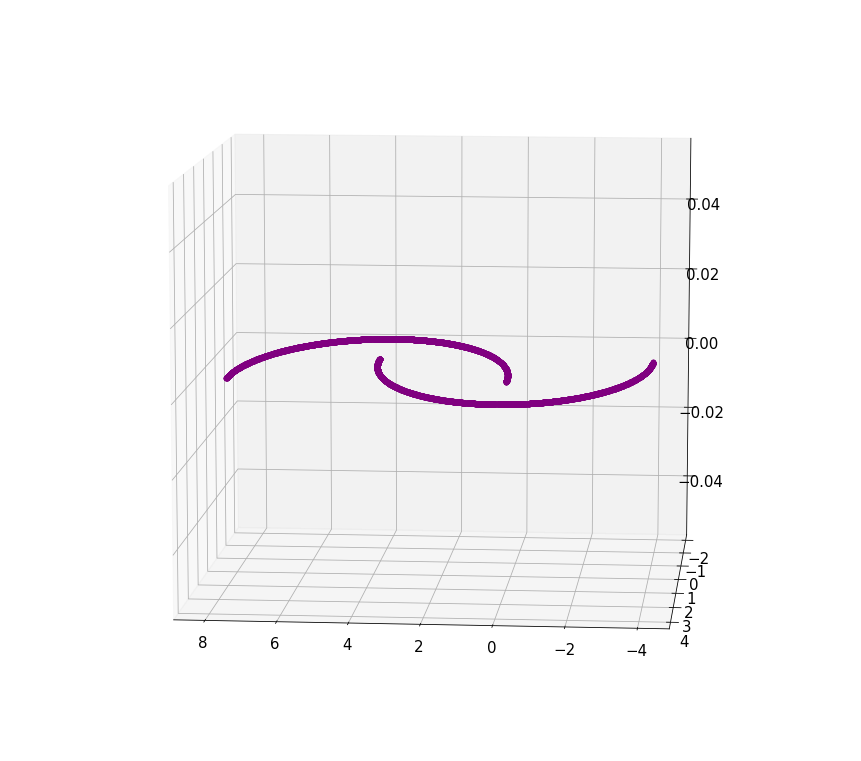

In [17]:
plot_data( moonsDataset)

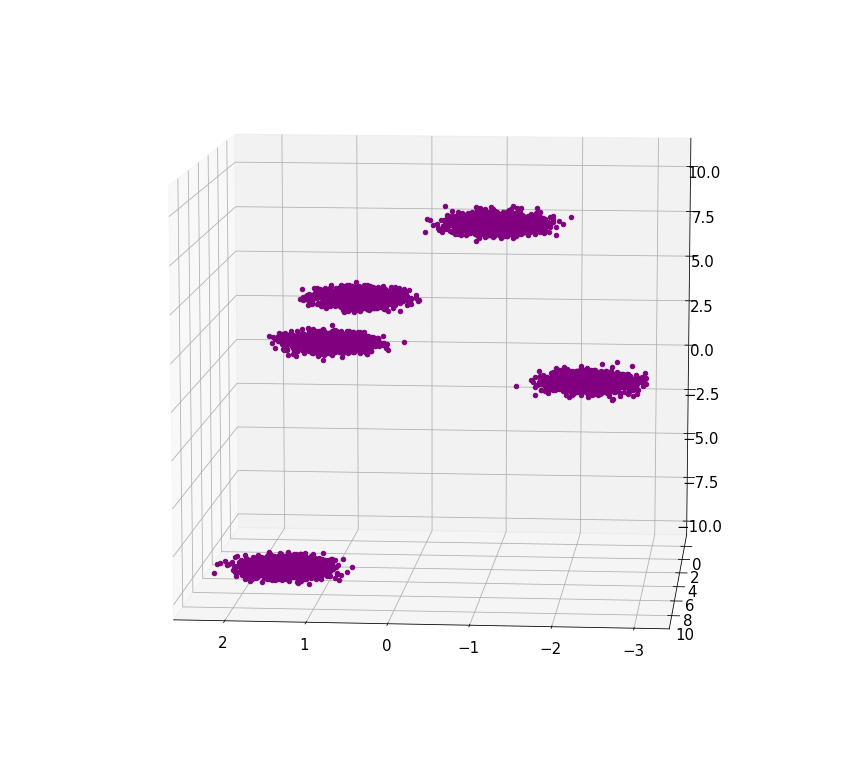

In [18]:
plot_data( blobsDataset )

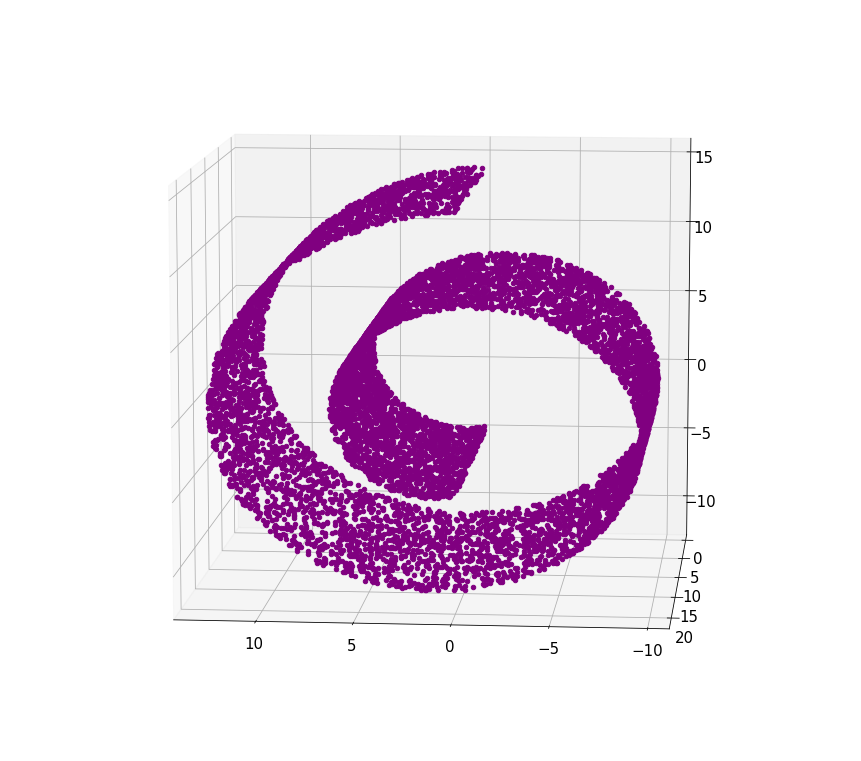

In [19]:
plot_data( swissRollDataset )

## Combined Dataset Plot
The train-set is shown in purple and the test-set is show in yellow.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.6 µs


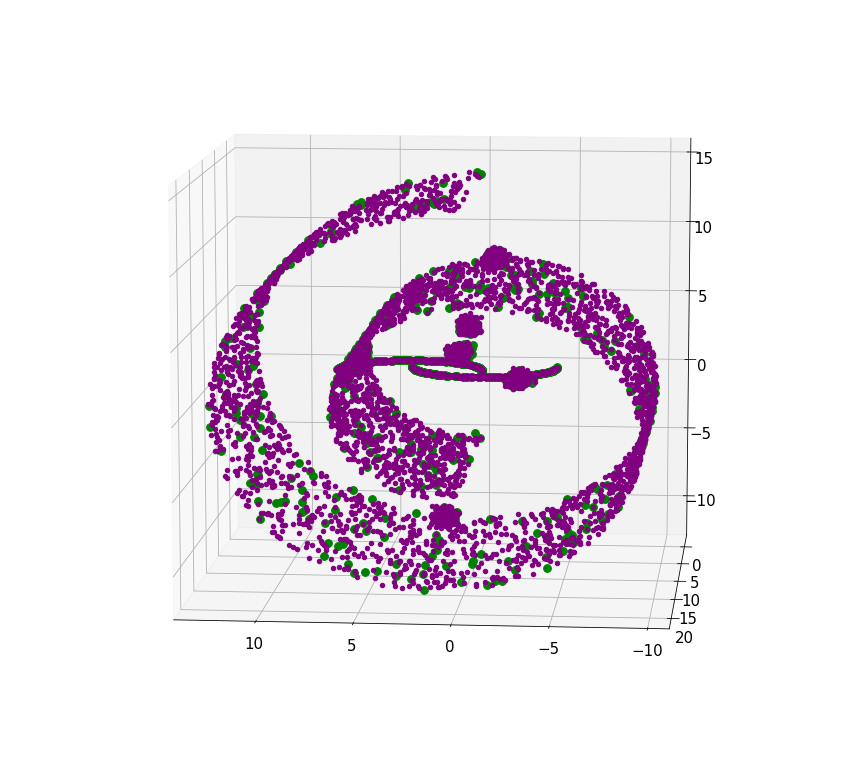

In [20]:
%time
if useMatplotlib3DFlag: 
    ax3D = plt.figure(figsize=(12,12)).gca(projection='3d')
    plot_data( X_train, 'purple', 10000, ax3D)
    plot_data( X_test, 'green', 1000, ax3D, 3)
else:
    ipv.figure()
    ipv_plot_data( X_train, 'purple', 100000, True)
    ipv_plot_data( X_test, 'green', 1000, True, 1.5)
    ipv.show()

------
# 3. ETL 
First we write the dataset to disk (as a comma separated file - CSV) so that we can subsequently demonstrate data loading.

In [21]:
%%time
pd.DataFrame(data = X_train).to_csv('X_train.csv.txt', index = False)
pd.DataFrame(data = X_test).to_csv('X_test.csv.txt', index = False)
pd.DataFrame(data = y_train).to_csv('y_train.csv.txt', index = False)
pd.DataFrame(data = y_test).to_csv('y_test.csv.txt', index = False)

CPU times: user 5min 43s, sys: 4.14 s, total: 5min 47s
Wall time: 5min 53s


In [22]:
!echo 'no data\n0' > warmup.csv # write a mini csv file used to initialize cuIO kernels

## Check Size of Data on Disk 
using the default value of `nTotalSamples = 5000000` should produce a training set of `~184MBs` in size.

In [23]:
!du -h *csv.txt

613M	X_test.csv.txt
1.8G	X_train.csv.txt
48M	y_test.csv.txt
144M	y_train.csv.txt


# 3.1 - Load Data

In [24]:
%%time 
startTime = time.time()

pd_X_train = pd.read_csv('X_train.csv.txt',  delimiter=',')
pd_X_test = pd.read_csv('X_test.csv.txt',  delimiter=',')
pd_y_train = pd.read_csv('y_train.csv.txt',  delimiter=',')
pd_y_test = pd.read_csv('y_test.csv.txt',  delimiter=',')

pandasIngestionTime = time.time() - startTime

CPU times: user 31.1 s, sys: 2.21 s, total: 33.3 s
Wall time: 33.3 s


In [25]:
# get column-names
f = open('X_train.csv.txt'); colNames = f.readline().strip().split(','); f.close()
# warmup rapids data ingestion engines [ cuio kernels ]
cudf.read_csv('warmup.csv')

<cudf.DataFrame ncols=1 nrows=1 >

In [26]:
%%time
startTime = time.time()

cudf_X_train = cudf.read_csv('X_train.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_X_test = cudf.read_csv('X_test.csv.txt', delimiter=',', skiprows=1, names=colNames, dtype=['float64', 'float64', 'float64'])
cudf_y_train = cudf.read_csv('y_train.csv.txt', dtype=['float64'])
cudf_y_test = cudf.read_csv('y_test.csv.txt', dtype=['float64'])

rapidsIngestionTime = time.time() - startTime

CPU times: user 2.5 s, sys: 1.2 s, total: 3.7 s
Wall time: 5.31 s


## Evaluate Load/Ingestion Speedup

In [27]:
pandasIngestionTime/rapidsIngestionTime

6.27616232047644

# 3.2 - Transform Data ( Normalize )
Transforming a dataset is a common requirement prior to training upstream models. For each feature in the dataset we remove the mean and divide by the standard deviation -- this makes each feature behave like a normally distributed variable (e.g. gaussian with 0 mean and unit variance). 

For the data on the CPU we can use the pre-built <a href='https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html'>sklearn.preprocessing.StandardScaler</a> function.
In the case of the GPU, we demonstrate how the same transformation can be built using a custom (user defined) function written as a <a href='http://numba.pydata.org/numba-doc/0.13/CUDAJit.html'>just-in-time numba kernel</a>. 

Note that we compute the mean and standard deviation statistics on the training data, and then apply the transformation to the training and test data (i.e., the test data is never seen when computing the mean & standard deviation).

In [28]:
%%time 
startTime = time.time()

scaler = sklearn.preprocessing.StandardScaler().fit(pd_X_train) # normalize
pd_X_train = scaler.transform(pd_X_train)
pd_X_test = scaler.transform(pd_X_test)

pandasTransformTime = time.time() - startTime 

CPU times: user 2.42 s, sys: 1.48 s, total: 3.89 s
Wall time: 3.89 s


-----

In [29]:
@cuda.jit 
def gpu_scale(outputCol, colGPUArrays, colMeans, colStDevs):
    iRow = cuda.grid(1)
    if iRow < colGPUArrays.size:
        outputCol[iRow] = ( colGPUArrays[iRow] - colMeans ) / ( colStDevs + 1e-10 )

In [30]:
def standard_scaler_numba( targetDF, trainMeans = None, trainStdevs = None):
    nRows = targetDF.shape[0]
    
    blockSize = 128
    blockCount = nRows // blockSize + 1
    scaledDF = cudf.DataFrame()
    
    if trainMeans is None and trainStdevs is None:
        trainMeans = {}
        trainStdevs = {}
        
    for iColName in targetDF.columns:
        colGPUArray = targetDF[iColName].to_gpu_array()
        outputCol = cuda.device_array ( shape=(nRows), dtype=colGPUArray.dtype.name)       
        if iColName not in trainMeans.keys():
            trainMeans[iColName] = targetDF[iColName].mean()
        if iColName not in trainStdevs.keys():
            trainStdevs[iColName] = targetDF[iColName].std()
        gpu_scale[(blockCount),(blockSize)](outputCol, colGPUArray, trainMeans[iColName], trainStdevs[iColName])
        scaledDF.add_column(name=iColName, data = outputCol)    
        
    return scaledDF, trainMeans, trainStdevs

In [31]:
_, _, _ = standard_scaler_numba( cudf_X_test.copy().head(2) ) # warmup

In [32]:
%%time
startTime = time.time()

cudf_X_train, trainMeans, trainStdevs = standard_scaler_numba( cudf_X_train )
cudf_X_test, _, _ = standard_scaler_numba( cudf_X_test, trainMeans, trainStdevs )

rapidsTransformTime = time.time() - startTime

CPU times: user 60 ms, sys: 44 ms, total: 104 ms
Wall time: 327 ms


## Evaluate Transform Speedup

In [33]:
pandasTransformTime/rapidsTransformTime

11.892088480958313

## Verify [approximate] numerical equivalence between CPU and GPU

In [34]:
trainMeans, scaler.mean_, trainStdevs, scaler.scale_

({'0': 1.3108170421896297, '1': 5.996890413248739, '2': 0.48552973857322895},
 array([1.31081704, 5.99689041, 0.48552974]),
 {'0': 4.5046723079074455, '1': 5.745180377820322, '2': 5.236692024607597},
 array([4.50467225, 5.7451803 , 5.23669195]))

In [35]:
print(pd_X_test[0:2,:])

[[ 1.11902579  0.95446246  0.0663404 ]
 [ 0.41418789 -0.62069424 -0.09271688]]


In [36]:
print(cudf_X_test.head(2))

                     0                    1                    2
0    1.119025776968502   0.9544624424954455  0.06634039974801512
1  0.41418788831329817  -0.6206942290710501  -0.0927168785718957


-----
# 4. - Model Building with XGBoost
-----
XGBoost is a popular algorithm for classification. It uses a sequence of decision trees built in succession such that each new tree attempts to correct the errors made by its predecessors (analogy to multiple golf swings [ each improving on the past ] to reach a target). For a deeper dive into how XGBoost works check out the following dev blog: <br>
> https://devblogs.nvidia.com/gradient-boosting-decision-trees-xgboost-cuda/

<img src='https://raw.githubusercontent.com/miroenev/rapids/master/xgboost.png' width =90%>
<center> img src: https://explained.ai/gradient-boosting/L2-loss.html </center>

## Prepare Data for Training

In [37]:
#  X_train, X_test, y_train, y_test

In [38]:
X = pd_X_train
y = pd_y_train

In [39]:
train_DataAndLabelsGPU = xgboost.DMatrix(pd_X_train, label=np.squeeze(pd_y_train))
test_DataAndLabelsGPU = xgboost.DMatrix(pd_X_test, label=np.squeeze(pd_y_test))

/conda/envs/rapids/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:604: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/conda/envs/rapids/lib/python3.7/site-packages/xgboost-0.81-py3.7.egg/xgboost/core.py:605: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


## Specify Model Parameters

noteable parameters: [ to see all available options execute '?xgboost.XGBClassifier' in a new cell] 

* __max_depth__ : int [ default = 3 ] -- Maximum tree depth for base learners.
* __n_estimators__ : int [ default = 100 ] -- Number of boosted trees to fit.
* __n_jobs__ : int [ default = 1 ] -- Number of parallel threads used to run xgboost.

-----
# 4.1 - Model Training

## Functions that run a single experiment on either the CPU or GPU

In [43]:
def train_cpu_xgboost ( maxDepth = 3, nTrees=100):
    
    # set params
    nCores = !nproc --all
    nCores = 1 #int(nCores[0])

    paramsCPU = {
        'tree_method': 'hist',
        'objective': 'multi:softmax',
        'num_class': 3,
        'n_jobs': nCores
    }
    xgBoostModelCPU = xgboost.XGBClassifier(max_depth = maxDepth, 
                                        n_estimators = nTrees,
                                        tree_method = paramsCPU['tree_method'],
                                        objective = paramsCPU['objective'],
                                        num_class = paramsCPU['num_class'],
                                        n_jobs = paramsCPU['n_jobs'])    
    # fit model
    startTime = time.time()
    xgBoostModelCPU.fit( X, y );
    cpuXGBoostTime = time.time() - startTime    
    
    # accuracy
    yPredTestCPU = xgBoostModelCPU.predict(pd_X_test)
    score = accuracy_score(pd_y_test, yPredTestCPU) 
    
    return cpuXGBoostTime, score, xgBoostModelCPU
    
def train_gpu_xgboost ( maxDepth = 3, nTrees=100):
    
    # set params
    nCores = !nproc --all
    nCores = int(nCores[0])

    paramsGPU = {
        'max_depth': maxDepth,        
        'objective': 'multi:softmax',
        'num_class': 3,
        'tree_method': 'gpu_hist',
        'random_state': 0,
    }

    startTime = time.time()
    xgBoostModelGPU = xgboost.train( dtrain = train_DataAndLabelsGPU, params = paramsGPU, num_boost_round = nTrees )
    gpuXGBoostTime = time.time() - startTime
    
    # accuracy
    yPredTestGPU = xgBoostModelGPU.predict(test_DataAndLabelsGPU)
    score = accuracy_score(pd_y_test, yPredTestGPU) 
    
    return gpuXGBoostTime, score, xgBoostModelGPU

In [44]:
paramSetGPU = [ [12, 1] ]#, [3, 10], [6,1], [6,10], [12, 1], [12, 10], [25, 1] ]

paramSetCPU = paramSetGPU
nExperiments = len(paramSetGPU)
nRepetitions = 2

In [45]:
for iExperiment in range(nExperiments):
    
    maxDepth = paramSetGPU[iExperiment][0]
    nTrees = paramSetGPU[iExperiment][1]
    
    for iRepetitions in range(nRepetitions):
        cpuXGBoostTime, score, xgBoostModelCPU = train_cpu_xgboost ( maxDepth, nTrees )
        print('CPU maxDepth: {}, nTrees: {}, time: {}, score: {} '.format(maxDepth, nTrees, cpuXGBoostTime, score))

    time.sleep(5)
    
    for iRepetitions in range(nRepetitions):
        gpuXGBoostTime, score, xgBoostModelCPU = train_gpu_xgboost ( maxDepth, nTrees )
        print('GPU maxDepth: {}, nTrees: {}, time: {}, score: {} '.format(maxDepth, nTrees, gpuXGBoostTime, score))

CPU maxDepth: 12, nTrees: 1, time: 60.15789270401001, score: 0.99995432 
CPU maxDepth: 12, nTrees: 1, time: 60.64729928970337, score: 0.99995432 
GPU maxDepth: 12, nTrees: 1, time: 2.2875711917877197, score: 0.99995384 
GPU maxDepth: 12, nTrees: 1, time: 2.223238706588745, score: 0.99995384 
